# DataJoint tutorial
Feb 2024

Vyom Raval

Before running our imports, make sure your docker container is running with the terminal command `docker-compose up -d`

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob

import sys
sys.path.append('../dj_modules/')
import dj_metadata as djm
import dj_populate as djp

import pandas as pd
import sys
import spikeoutputs as so
import spikeplots as sp

[2024-10-02 13:29:43,998][INFO]: Connecting root@127.0.0.1:3306
[2024-10-02 13:29:44,120][INFO]: Connected root@127.0.0.1:3306


Let's connect to the datajoint server hosted in our docker container.

In [2]:
dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'

In [3]:
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

Make sure you've set paths in dj_populate

In [4]:
print(djp.STR_NAS_PATH)
print(djp.STR_ANALYSIS_PATH)
print(djp.STR_SORT_PATH)

/Volumes/data/
/Volumes/data/analysis/
/Volumes/data/data/sorted/


Load metadata

In [5]:
# Put path to NAS array json's here
str_metadata_dir = '/Volumes/data/data/metadata/json/'

In [7]:
# This may take a few minutes if running for the first time.
djm.load_metadata(str_metadata_dir)
djp.load_chunks_and_files()
# djp.load_typing()

Added 0 new experiments
20230825C not in Experiment table.
20230825C not in Experiment table.
20230825C not in Experiment table.
20240606H not in Experiment table.
20240611H not in Experiment table.
20240611H not in Experiment table.
20240627H not in Experiment table.
20240627H not in Experiment table.
20240717H not in Experiment table.
20240717H not in Experiment table.
20240717H not in Experiment table.
Added 0 new data files


In [8]:
# Download our typing notes spreadsheet as csv and put path here
djp.load_typing_notes(str_csv='/Users/racheloaks-leaf/Desktop/lab/SortedData - Sheet1.csv')

Inserted 97 typing notes


# Datatables.

This diagram shows our DataTable hierarchy. You can hover over each node to see the table definition.

Green rectangles are "Manual" (i.e. populated by us with our dj_populate functions)

Red circles are "Computed" (from parent tables)

In [8]:
# Thick solid line means no new attribute added to foreign key
dj.Diagram(djm.schema)

ValueError: Node names and attributes should not contain ":" unless they are quoted with "".                    For example the string 'attribute:data1' should be written as '"attribute:data1"'.                    Please refer https://github.com/pydot/pydot/issues/258

Isn't it beautiful? Don't worry if it's scary, we'll step through it. Let's fetch our top level Experiment table as a dataframe.

In [9]:
djm.Experiment().fetch(format='frame').head()

,animal_id
date_id,
20220406C,
20220412C,
20220420C,
20220426C,
20220518,


Nice, it's a list of date IDs for each MEA experiment. The animal_id field hasn't been populated yet.

Let's look at the protocol datatable and query it for the fast noise protocol

In [10]:
(djm.Protocol() & f'protocol_id="manookinlab.protocols.DovesMovie"').fetch(format='frame').head()

,,n_groups,n_blocks
date_id,protocol_id,,
20220426C,manookinlab.protocols.DovesMovie,1,11
20220909C,manookinlab.protocols.DovesMovie,3,3
20230411C,manookinlab.protocols.DovesMovie,1,1
20230418C,manookinlab.protocols.DovesMovie,1,1
20230516C,manookinlab.protocols.DovesMovie,1,1


This is nice but can be tedious to find the full protocol id.

Let's use the `search_protocol` method to search this column with a substring and return all matches.

In [11]:
ls_protocols = djm.search_protocol('SpatialNoise')
print(ls_protocols)

['manookinlab.protocols.DisplacedSpatialNoise', 'manookinlab.protocols.FlashedSpatialNoise', 'manookinlab.protocols.SpatialNoise']


Let's now input these protocol IDs to `chunk_id_protocol` to get all the metadata.

In [12]:
df_meta = djm.meta_from_protocol(ls_protocols)
df_meta

OperationalError: (1812, 'Tablespace is missing for table `vyomr_tutorial`.`epoch_block`.')

Great, we have the date_id, data_file, and chunk_ids of all experiments with these protocols!

## Epoch level queries

Let's say we want to do a more specific query on the level of epoch parameters. The parameters json in the Epoch() table lets us do that!

For eg-for MovingChromaticBar, let's first see what the unique values for 'speed' are.

In [13]:
str_protocol = ls_protocols[0]
str_protocol

'manookinlab.protocols.DisplacedSpatialNoise'

In [14]:
# I'll project the Epoch table to pull out just the speed parameter for every epoch of this protocol.
idx = (djm.Epoch() & f'protocol_id="{str_protocol}"').proj(stimulusIndices="parameters->>'$.stimulusIndices'")
idx

OperationalError: (1812, 'Tablespace is missing for table `vyomr_tutorial`.`epoch`.')

In [30]:
idx = np.unique(idx.fetch('stimulusIndices')).astype(str)
np.sort(idx)

array(['[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 6, 12, 18, 24, 30, 40, 50, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 2, 6, 12, 18, 24, 30, 40, 50, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 2, 6, 12, 18, 24, 30, 40, 50, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 2, 6, 12, 18, 24, 30, 40, 50, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 2, 6, 12, 18, 24, 30, 40, 50]',
       '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36

Awesome, now let's get the metadata for experiments where any epochs had 2000 speed.

In [32]:
epochs = djm.query_epochs('stimulusIndices','[2, 6, 12, 15, 18, 24, 30, 40, 50]', str_protocol=str_protocol)
epochs

QuerySyntaxError: ('You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near \'[2, 6, 12, 15, 18, 24, 30, 40, 50]))AND( (protocol_id="manookinlab.protocols.Dov\' at line 1', 'SELECT `date_id`,`protocol_id`,`group_idx`,`data_file`,`block_idx`,`epoch_idx`,`bath_temperature` FROM `vyomr_tutorial`.`epoch` WHERE ( ( (parameters->>\'$.stimulusIndices\'=[2, 6, 12, 15, 18, 24, 30, 40, 50]))AND( (protocol_id="manookinlab.protocols.DovesMovie"))) LIMIT 13')

QuerySyntaxError: ('You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near \'[2, 6, 12, 15, 18, 24, 30, 40, 50]))AND( (protocol_id="manookinlab.protocols.Dov\' at line 1', 'SELECT `date_id`,`protocol_id`,`group_idx`,`data_file`,`block_idx`,`epoch_idx`,`bath_temperature` FROM `vyomr_tutorial`.`epoch` WHERE ( ( (parameters->>\'$.stimulusIndices\'=[2, 6, 12, 15, 18, 24, 30, 40, 50]))AND( (protocol_id="manookinlab.protocols.DovesMovie"))) LIMIT 13')

In [17]:
df_meta = djm.meta_from_epochs(epochs)

Chunk_id not found for data files: ['data011']


It seems chunk_id info was not found for data011. Looking back on the NAS drive, indeed 20230314C_chunk1.txt is missing.

No matter, we will use what we found and come back to this.

In [19]:
df_meta

,,,,,,frame_times,n_epochs
date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,,
20230314C,manookinlab.protocols.MovingChromaticBar,0,data018,2,chunk2,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",30


In [20]:
df_ct = djm.celltyping_from_meta(df_meta, verbose=True)
df_ct

num_cells  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                     
20230314C manookinlab.protocols.FastNoise 1         data012         0         chunk2   data012          kilosort2 1                    /Volumes/data-1/analysis/20230314C/chunk2/kilos...       1248   
                                                                                                                                       /Volumes/data-1/analysis/20230314C/chunk2/kilos...       1248   

                                                                                                                                                                                           num_goodcells  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                         
20230314C manookinlab.protocols.FastNoise 1         data012         0         chunk2   data012          kilosort2 1                    /Volumes/data-1/analysis/20230314C/chunk2/kilos...           1248   
                                                                                                                                       /Volumes/data-1/analysis/20230314C/chunk2/kilos...           1248   

                                                                                                                                                                                           num_on_p  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                    
20230314C manookinlab.protocols.FastNoise 1         data012         0         chunk2   data012          kilosort2 1                    /Volumes/data-1/analysis/20230314C/chunk2/kilos...        71   
                                                                                                                                       /Volumes/data-1/analysis/20230314C/chunk2/kilos...        71   

                                                                                                                                                                                           num_off_p  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                     
20230314C manookinlab.protocols.FastNoise 1         data012         0         chunk2   data012          kilosort2 1                    /Volumes/data-1/analysis/20230314C/chunk2/kilos...         73   
                                                                                                                                       /Volumes/data-1/analysis/20230314C/chunk2/kilos...         73   

                                                                                                                                                                                           num_on_m  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                    
20230314C manookinlab.protocols.FastNoise 1         data012         0         chunk2   data012          kilosort2 1                    /Volumes/data-1/analysis/20230314C/chunk2/kilos...        40   
                                                                                                                                       /Volumes/data-1/analysis/20230314C/chunk2/kilos...        40   

                                                                                                                                                                              

Fantastic, we have found the cell typing files for our date and chunk of interest. Minor notes:
- It seems both .txt files might have duplicate content as number of main cell types matches.
- num_sbc is 0 as no clusters with the label 'SBC' were found

In [21]:
# Drop first row from df_ct to keep only 2nd classification file.
df_ct = df_ct.iloc[1:]

Let's see any typing notes for this date and chunk.

You can look this up on the SortedData spreadsheet, or query TypingNotes table which should have same info

In [16]:
str_date = '20230314C'
str_chunk = 'chunk2'
djm.TypingNotes() & f'date_id="{str_date}"' & f'chunk_id="{str_chunk}"'

date_id date id of experiment,protocol_id,group_idx,noise_data_file,block_idx,chunk_id,noise_data_files All data files included in WN analysis,algorithm Spike Sorting algorithm,"b_typing_file_exists 0: false, 1: true",typing_file,quality,typing_status
20230314C,manookinlab.protocols.FastNoise,1,data012,0,chunk2,data012,kilosort2,1,/Volumes/data/analysis/20230314C/chunk2/kilosort2/kilosort2.classification.txt,Medium,Unknown
20230314C,manookinlab.protocols.FastNoise,1,data012,0,chunk2,data012,kilosort2,1,/Volumes/data/analysis/20230314C/chunk2/kilosort2/kilosort2.classification_fmr.txt,Medium,Unknown


## Plotting mosaics.

Let's load the STA Fit params into datajoint for this dataset.

In [17]:
str_algo = 'kilosort2'
djp.load_sta_fits(str_date, str_chunk, str_algo)

OperationalError: (1812, 'Tablespace is missing for table `vyomr_tutorial`.`s_t_a_fit`.')

Let's use my SpikeOutputs class and spikeplots module to take our metadata and data, put it together in a nice object, and plot mosaics.

In [15]:
def create_data_objs(df_meta, df_ct, algo='kilosort2'):
    # Move multiindex to columns
    df_meta = df_meta.reset_index()
    df_ct = df_ct.reset_index()

    # Create SpikeOutputs objects for each date-chunk pair with a valid typing file.
    d_data_objs = {}
    
    # Iterate through all date_id and chunk_id in df_ct
    df_ct = df_ct[df_ct['algorithm']==algo]

    dates = df_ct['date_id'].unique()
    for date_id in dates:
        chunks = df_ct[df_ct['date_id']==date_id]['chunk_id'].unique()

        for chunk_id in chunks:
            typing_files = df_ct[(df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id)]['typing_file'].unique()

            for idx_t, typing_file in enumerate(typing_files):
                # Get sum of num_on_p etc for each typing file
                mask = (df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id) & (df_ct['typing_file']==typing_file)
                n_cells = df_ct[mask].loc[:, 'num_on_p':].values.sum()
                if n_cells==0:
                    print(f"ERROR: {typing_file} has no cell types corresponding to defined labels")
                else:
                    file_names = df_meta[(df_meta['date_id']==date_id) & (df_meta['chunk_id']==chunk_id)]['data_file'].values
                    
                    d_paths =  {
                    "str_experiment": date_id,
                    
                    "ls_filenames": list(file_names),
                    "dataset_name": algo,
                    "str_algo": algo,
                    "str_chunk": chunk_id,
                    "str_classification": typing_file,
                    "str_protocol": "noise"
                    }

                    data = so.SpikeOutputs(**d_paths)
                    df_sta = (djm.STAFit() & f'date_id="{str_date}"' & f'chunk_id="{str_chunk}"' & f'algorithm="{str_algo}"').fetch(format='frame').reset_index()
                    df_sta = df_sta.set_index('cell_id')
                    data.load_sta(df_sta=df_sta)
                    
                    str_key = f'{date_id}_{chunk_id}_{idx_t}'
                    d_data_objs[str_key] = data
    return d_data_objs

In [26]:
d_data_objs = create_data_objs(df_meta, df_ct, algo='kilosort2')

Loading STA from datajoint
Loaded STA for 1248 cells.


In [27]:
d_data_objs.keys()

dict_keys(['20230314C_chunk2_0'])

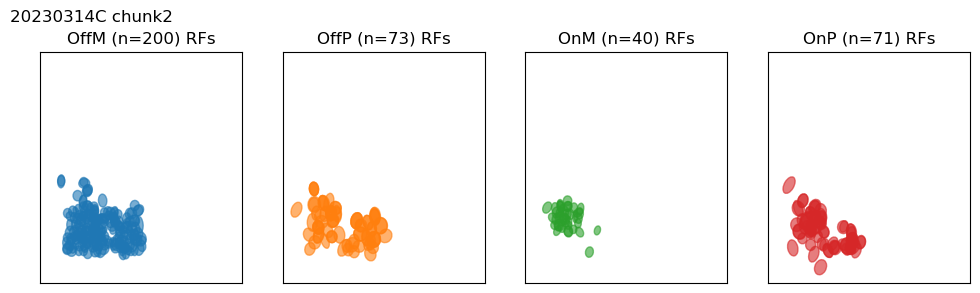

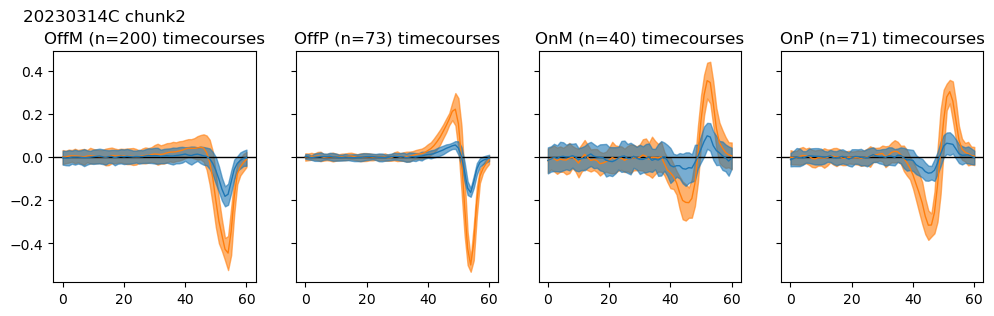

In [28]:
data = d_data_objs['20230314C_chunk2_0']
axs=sp.plot_type_rfs_and_tcs(data)

## Loading CRFs

Let's see if there were any CRF protocols run on this date and chunk.

In [29]:
str_crf_protocol = 'manookinlab.protocols.ContrastResponseGrating'
query = djm.DataFile() & f'date_id="{str_date}"' & f'chunk_id="{str_chunk}"' & f'protocol_id="{str_crf_protocol}"'
query

date_id date id of experiment,protocol_id,group_idx,data_file,block_idx,chunk_id
20230314C,manookinlab.protocols.ContrastResponseGrating,0,data013,0,chunk2


Great, let's now compute and load CRF F1 for this.

In [30]:
crf_data_file = query.fetch('data_file')[0]
djp.load_crf(str_date, crf_data_file, str_algo)

CRF data already exists for 20230314C data013


Now let's plot mosaics colored by 5% CRF F1. Using some convenience functions here from crf_analysis.

In [31]:
import crf_analysis as crf

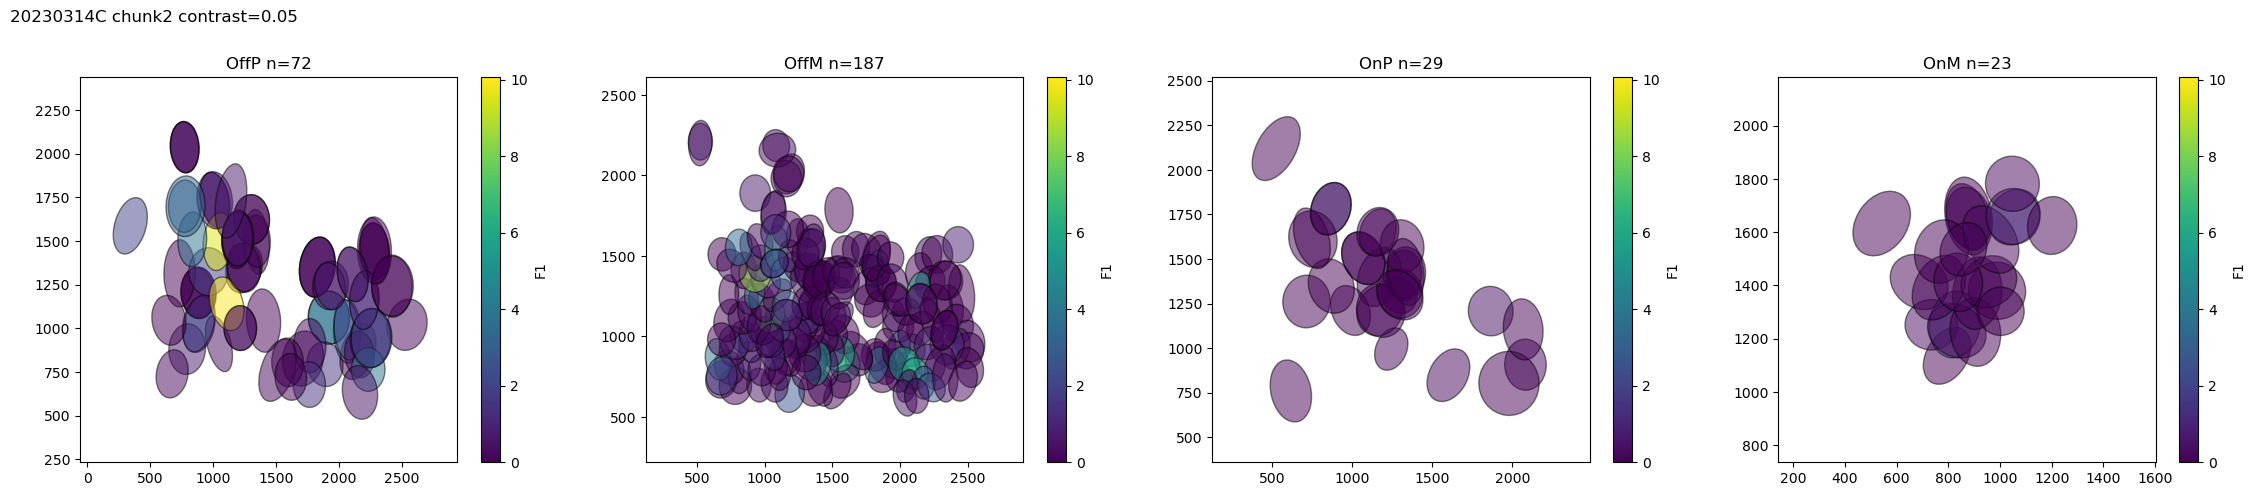

In [32]:
axs = crf.plot_crf_mosaic(data, n_contrast=0.05)

## Loading PSTHs

Now we can use the `load_psth` function which uses symphony_data methods to load the PSTH as well as the ISI!

In [33]:
print(str_protocol)
ls_param_names = ['orientation', 'speed', 'contrast', 'barSize']
bin_rate = 100.0
data.load_psth(str_protocol, ls_param_names, bin_rate)

manookinlab.protocols.MovingChromaticBar
Processing group 1 of 1 and block 1 of 1
Loading ISI for manookinlab.protocols.MovingChromaticBar ['data018']...
Processing group 1 of 1 and block 1 of 1
Loaded ISI for 1194 cells.


We now have everything we need for further analysis yay :)

In [34]:
data.stim['unique_params']

{'orientation': array([0]),
 'speed': array([2000]),
 'contrast': array([-1,  1]),
 'barSize': array([ 500, 4000])}

In [35]:
data.print_stim_summary()

epoch length: 8000.0 ms
Total epochs: 30
pre: 500.0 ms; stim: 7000.0 ms; tail: 500.0 ms
pre pts: 50; stim pts: 700; tail pts: 50
bin rate: 100.0 Hz; bin dt: 10.0 ms


For instance, let's plot OnP PSTHs when contrast was 1

In [36]:
n_contrast = 1
epoch_mask = np.where(np.array(data.stim['params']['contrast'])==n_contrast)
print(f'Number of trials with speed {n_contrast} = {len(epoch_mask[0])}')

Number of trials with speed 1 = 15


In [37]:
# Let's look at the shape of our spike_dict for each cell ID. It should tell us the epochs x timepts
eg_id = data.ARR_CELL_IDS[0]
data.spikes['spike_dict'][eg_id].shape

(30, 800)

Text(0.5, 1.0, 'On Parasol PSTH for contrast 1')

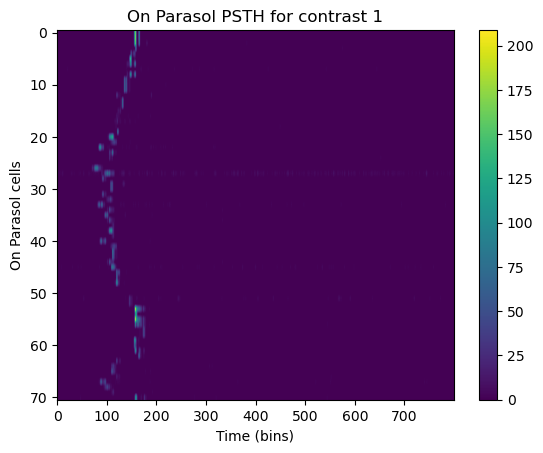

In [38]:
onp_ids = data.types.d_main_IDs['OnP']

onp_psth = [data.spikes['spike_dict'][onp_id][epoch_mask].mean(axis=0) for onp_id in onp_ids]
onp_psth = np.array(onp_psth)

plt.imshow(onp_psth, aspect='auto')
plt.colorbar()
plt.xlabel('Time (bins)')
plt.ylabel('On Parasol cells')
plt.title(f'On Parasol PSTH for contrast {n_contrast}')